Load the data set

In [2]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [3]:
# Load the dataset from an Excel file
dataset = pd.read_excel("new_labeled_dataset_withNOs.xlsx", engine="openpyxl")

# Display the first few rows
print("First rows of the dataset:")
print(dataset.head())

# Show dataset information (columns, data types, non-null values)
print("\nDataset Information:")
print(dataset.info())

# Check for missing values in each column
print("\nMissing Values Per Column:")
print(dataset.isnull().sum())


First rows of the dataset:
                                                text  class_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech
1                                       Στα τέσσερα.           no
2                                 Στα τέσσερα εσείς.           no
3                                       Στα τέσσερα.           no
4                                            Λοιπόν.           no

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         866 non-null    object
 1   class_label  866 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB
None

Missing Values Per Column:
text           0
class_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [5]:
def clean_text(text):
    """
    Cleans the input text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    """
    if not isinstance(text, str):
        return ""  # Return empty string if input is not valid

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    return text

# Apply text cleaning function to dataset
dataset['cleaned_text'] = dataset['text'].apply(clean_text)

# Display sample cleaned text
print("\nSample Cleaned Text:")
print(dataset[['text', 'cleaned_text']].head())



Sample Cleaned Text:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης  σελίδων η οποία δεν έγινε χωρίς...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Class Distribution:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64


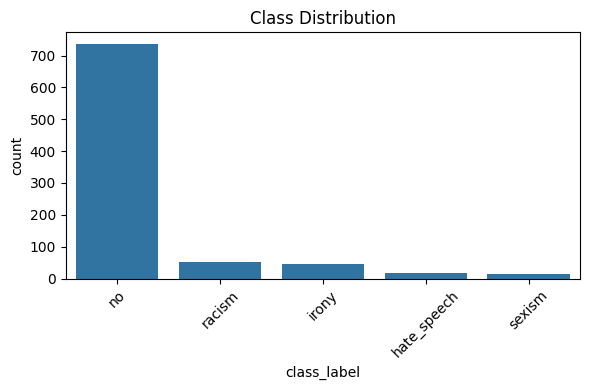


Text Length Statistics:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


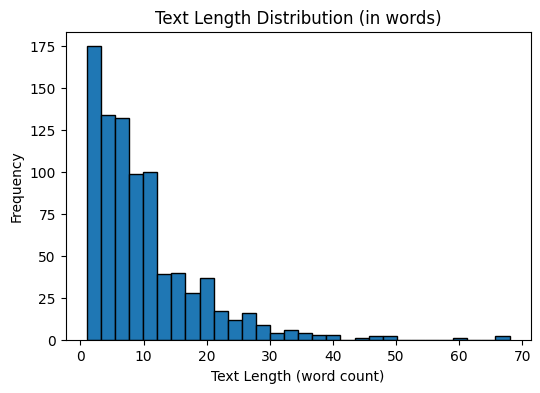

NameError: name 'word_tokenize' is not defined

In [7]:
# --- Class Distribution ---
print("Class Distribution:")
print(dataset['class_label'].value_counts())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='class_label', order=dataset['class_label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Text Length Analysis ---
# Compute text length (number of words)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))

# Display basic statistics on text length
print("\nText Length Statistics:")
print(dataset['text_length'].describe())

# Plot distribution of text length
plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Text Length Distribution (in words)")
plt.xlabel("Text Length (word count)")
plt.ylabel("Frequency")
plt.show()

# --- Word Frequency Analysis ---
# Tokenize cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# Flatten all tokens into a single list
all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)

# Display the 20 most common words
print("\nTop 20 Most Frequent Words:")
print(counter.most_common(20))

# Plot most frequent words
common_words = counter.most_common(20)
words, freqs = zip(*common_words)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Tokenize the cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# Remove punctuation and numbers from tokens
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# Define and customize Greek stopwords
default_stopwords = set(stopwords.words('greek'))
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}  # Keep some words
custom_stopwords.update(extra_stopwords)

# Define important words to keep
important_words = {
    "ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
    "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"
}
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nFinal stopwords list:")
print(custom_stopwords)

# Remove stopwords from tokens
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

# Display sample processed tokens
print("\nExample tokens after stopword removal:")
print(dataset[['cleaned_text', 'tokens']].head())



Final stopwords list:
{'ἀπό', 'τε', 'πρὸς', 'τοιοῦτος', 'της', 'αυτό', 'Να', 'ειστε', 'γε', 'ἐφ', 'αυτοι', 'Είναι', 'ἵνα', 'σύν', 'ὅ', 'μια', 'ὑπό', 'οὐδὲν', 'δεν', 'παρ', 'αὖ', 'ποιων', 'ειναι', 'δαίσ', 'ὥστε', 'μή', 'μη', 'μέν', 'στο', 'ὡσ', 'δε', 'οσο', 'Εγώ', 'εκεινουσ', 'μήτε', 'ἐπεὶ', 'τον', 'αυτή', 'ἥ', 'αντι', 'και', 'γα', 'ποιοι', 'από', 'πρὸ', 'αυτα', 'τοί', 'ὑπ', 'εἰ', 'ἣ', 'διά', 'ὅστισ', 'πολύ', 'κατὰ', 'απο', 'μας', 'τοτε', 'ἑαυτοῦ', 'ἄν', 'ἐὰν', 'μετά', 'ἐγώ', 'οτι', 'τὸν', 'οὐδέ', 'στη', 'των', 'τόν', 'ειμαστε', 'αὐτόσ', 'δαὶς', 'τη', 'για', 'σας', 'αυτων', 'γα^', 'παρὰ', 'ὥς', 'αυτοσ', 'ὃ', 'εἴ', 'ἐξ', 'σὸς', 'εἰσ', 'τῇ', 'τότε', 'ἐστι', 'ποτε', 'ἐκ', 'εισαι', 'ἐν', 'τοιοῦτοσ', 'ὅδε', 'ποῦ', 'οὕτω', 'ὅτε', 'του', 'καί', 'οὔτε', 'ἐπὶ', 'ἃ', 'Δεν', 'η', 'ποιο', 'εἴτε', 'που', 'μετα', 'ὑπὸ', 'ὃς', 'οι', 'αἵ', 'είναι', 'ἐπί', 'έχει', 'ὅτι', 'ἡ', 'μεθ', 'μὴν', 'τὰ', 'τα', 'θα', 'οὗτος', 'μου', 'ένα', 'γοῦν', 'μἐν', 'οὐδὲ', 'ενω', 'οἷς', 'οὐδεὶς', 'αυτο', 'οὐκ', 'ὅσ', 'ὅστι

Βήμα 4: Undersampling της Κλάσης "no" 

In [9]:
# Display class distribution before undersampling
print("\nClass distribution before undersampling:")
print(dataset['class_label'].value_counts())

# Separate the "no" class and the rest of the dataset
dataset_no = dataset[dataset['class_label'] == 'no']
dataset_other = dataset[dataset['class_label'] != 'no']

# Randomly select 60 samples from the "no" class
dataset_no_sampled = dataset_no.sample(n=60, random_state=42)

# Combine the sampled "no" class with the rest of the dataset
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)

# Display class distribution after undersampling
print("\nClass distribution after undersampling:")
print(dataset_balanced['class_label'].value_counts())



Class distribution before undersampling:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64

Class distribution after undersampling:
no             60
racism         52
irony          46
hate_speech    17
sexism         15
Name: class_label, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [10]:
# Convert tokenized text into a single string for each sample
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))


Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [11]:

# Initialize TF-IDF vectorizer with a max of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Transform the processed text into a TF-IDF feature matrix
X = tfidf.fit_transform(dataset_balanced['processed_text'])

# Extract class labels
y = dataset_balanced['class_label']

# Print the shape of the resulting feature matrix
print("\nShape of TF-IDF Feature Matrix:", X.shape)



Shape of TF-IDF Feature Matrix: (190, 920)


↑ 866 δειγματα (οσες οι γραμμες του dataset)
2207 features που διατηρηθηκαν

NAIVE BASE k-folds HYPERPARAMETER TUNING CORRECT  SMOTE

              precision    recall  f1-score   support

      racism       0.29      0.35      0.32        17
      sexism       0.36      0.22      0.27        46
       irony       0.40      0.45      0.43        60
 hate_speech       0.53      0.54      0.53        52
          no       0.33      0.47      0.39        15

    accuracy                           0.41       190
   macro avg       0.38      0.41      0.39       190
weighted avg       0.41      0.41      0.40       190

Best hyperparameters: {'alpha': 0.1}
Confusion Matrix:
[[ 6  3  4  3  1]
 [ 6 10 15 12  3]
 [ 7  9 27  9  8]
 [ 2  5 15 28  2]
 [ 0  1  6  1  7]]


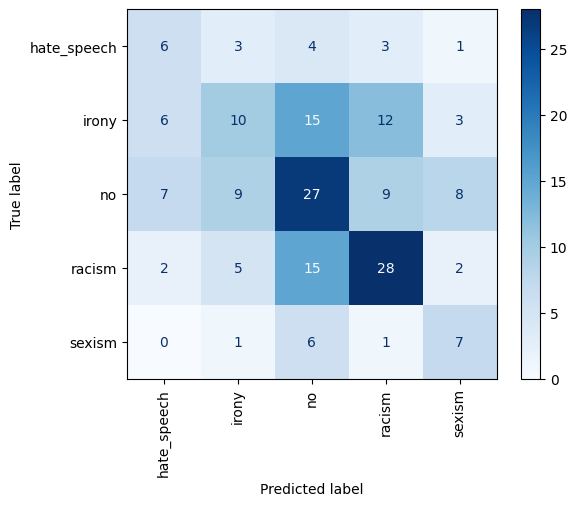

In [43]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the Naïve Bayes model
model = MultinomialNB()

# Define hyperparameters for tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]  # Laplace smoothing values
}

# GridSearchCV with K-Fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='f1_weighted', n_jobs=-1)

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]  # Split train and test sets
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Find the best hyperparameter using GridSearchCV
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_

    # Make a prediction
    y_pred = best_model.predict(X_test)

    # Store actual and predicted values
    Y_true.extend(y_test.values)
    Y_pred.extend(y_pred)

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Compute and display confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


NAIVE BASE CORRECT SMOTE ONLY ON THE TRAINING SET

              precision    recall  f1-score   support

      racism       0.18      0.35      0.24        17
      sexism       0.33      0.20      0.25        46
       irony       0.48      0.43      0.46        60
 hate_speech       0.64      0.54      0.58        52
          no       0.25      0.53      0.34        15

    accuracy                           0.41       190
   macro avg       0.38      0.41      0.37       190
weighted avg       0.44      0.41      0.41       190

Confusion Matrix:
[[ 6  3  3  2  3]
 [ 9  9 12  8  8]
 [11  9 26  5  9]
 [ 6  4 10 28  4]
 [ 1  2  3  1  8]]


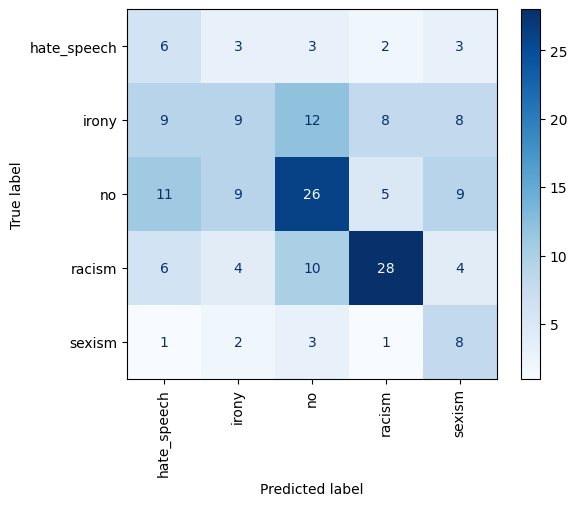

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Naïve Bayes model
model = MultinomialNB()

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]  # Split train and test sets
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])
    Y_pred.append(y_pred[0])

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute and display confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


NAIVE BASE - NO SMOTE

In [165]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Naïve Bayes model
model = MultinomialNB()

# Compute accuracy using LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (Naïve Bayes - LOO-CV): {np.mean(scores):.4f}")

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Extract labels

    # Train the model
    model.fit(X_train, y_train)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])  # Convert to scalar
    Y_pred.append(y_pred[0])  # Extract prediction

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute and display confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


Μέση Ακρίβεια (Naïve Bayes - LOO-CV): 0.4000
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.18      0.04      0.07        46
       irony       0.36      0.78      0.49        60
 hate_speech       0.56      0.52      0.54        52
          no       0.00      0.00      0.00        15

    accuracy                           0.40       190
   macro avg       0.22      0.27      0.22       190
weighted avg       0.31      0.40      0.32       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Leave-One-Out Cross-Validation (LOO-CV) 
αντί για :
Split the data into Training and Testing
λόγω λίγων δειγμάτων

LOGISTIC REGRESSION - NO SMOTE

In [168]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Compute mean accuracy using LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (LOO-CV): {np.mean(scores):.4f}")

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use `.iloc` only for `y`

    # Train the model
    model.fit(X_train, y_train)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])  # Convert to scalar
    Y_pred.append(y_pred[0])  # Extract prediction from NumPy array

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Compute mean accuracy using LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (LOO-CV): {np.mean(scores):.4f}")

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use `.iloc` only for `y`

    # Train the model
    model.fit(X_train, y_train)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])  # Convert to scalar
    Y_pred.append(y_pred[0])  # Extract prediction from NumPy array

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


Μέση Ακρίβεια (LOO-CV): 0.3947
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.20      0.04      0.07        46
       irony       0.36      0.83      0.50        60
 hate_speech       0.56      0.44      0.49        52
          no       0.00      0.00      0.00        15

    accuracy                           0.39       190
   macro avg       0.22      0.26      0.21       190
weighted avg       0.32      0.39      0.31       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

LOGISTIC REGRESSION CORRECT SMOTE ONLY ON TRAINING SET

              precision    recall  f1-score   support

      racism       0.43      0.18      0.25        17
      sexism       0.29      0.20      0.23        46
       irony       0.42      0.62      0.50        60
 hate_speech       0.52      0.56      0.54        52
          no       0.86      0.40      0.55        15

    accuracy                           0.44       190
   macro avg       0.50      0.39      0.41       190
weighted avg       0.45      0.44      0.43       190

Confusion Matrix:
[[ 3  4  7  3  0]
 [ 2  9 24 11  0]
 [ 0 10 37 12  1]
 [ 2  6 15 29  0]
 [ 0  2  6  1  6]]


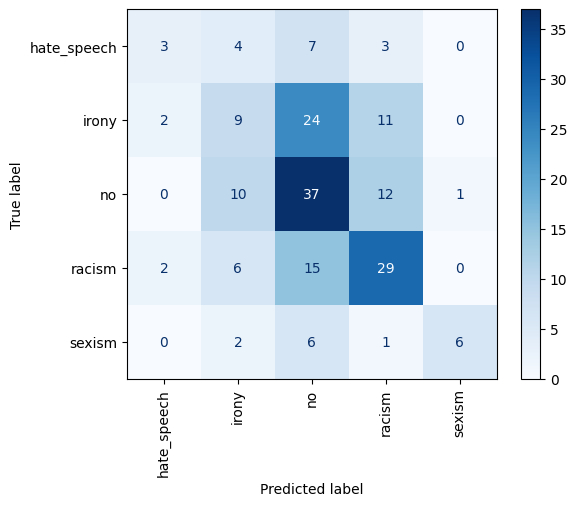

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Extract labels

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])
    Y_pred.append(y_pred[0])

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


RANDOM FOREST CORRECT SMOTE ONLY ON TRAINING SET

              precision    recall  f1-score   support

      racism       0.67      0.12      0.20        17
      sexism       0.44      0.09      0.15        46
       irony       0.37      0.93      0.53        60
 hate_speech       0.68      0.25      0.37        52
          no       1.00      0.40      0.57        15

    accuracy                           0.43       190
   macro avg       0.63      0.36      0.36       190
weighted avg       0.55      0.43      0.36       190

Confusion Matrix:
[[ 2  1 14  0  0]
 [ 0  4 38  4  0]
 [ 1  2 56  1  0]
 [ 0  2 37 13  0]
 [ 0  0  8  1  6]]


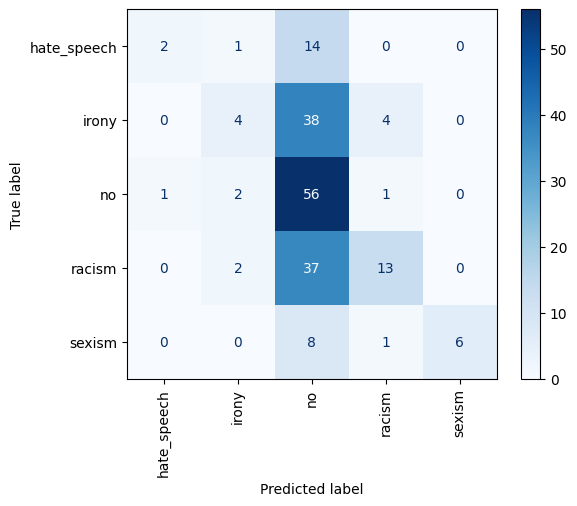

In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Extract labels

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.item())  # Convert to scalar
    Y_pred.append(y_pred[0])

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()


RANDOM FOREST - NO SMOTE

In [178]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluate model accuracy using LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (Random Forest without SMOTE - LOO-CV): {np.mean(scores):.4f}")

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Extract labels

    # Train the model
    model.fit(X_train, y_train)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])  # Convert to scalar
    Y_pred.append(y_pred[0])  # Extract prediction

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute and display confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


Μέση Ακρίβεια (Random Forest χωρίς SMOTE - LOO-CV): 0.4421
              precision    recall  f1-score   support

      racism       0.67      0.12      0.20        17
      sexism       0.43      0.07      0.11        46
       irony       0.38      0.98      0.54        60
 hate_speech       0.82      0.27      0.41        52
          no       1.00      0.40      0.57        15

    accuracy                           0.44       190
   macro avg       0.66      0.37      0.37       190
weighted avg       0.59      0.44      0.37       190



SVM - NO SMOTE

In [181]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define SVM model with a linear kernel
model = SVC(kernel='linear', random_state=42)

# Evaluate model accuracy using LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (SVM without SMOTE - LOO-CV): {np.mean(scores):.4f}")

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Pandas Series

    # Train the model
    model.fit(X_train, y_train)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.values[0])  # Convert to scalar
    Y_pred.append(y_pred[0])  # Extract prediction

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute and display confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')


Μέση Ακρίβεια (SVM χωρίς SMOTE - LOO-CV): 0.4368
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.35      0.15      0.21        46
       irony       0.38      0.75      0.51        60
 hate_speech       0.57      0.54      0.55        52
          no       1.00      0.20      0.33        15

    accuracy                           0.44       190
   macro avg       0.46      0.33      0.32       190
weighted avg       0.44      0.44      0.39       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

SVM CORRECT SMOTE ONLY ON TRAINING SET

              precision    recall  f1-score   support

      racism       0.75      0.18      0.29        17
      sexism       0.27      0.17      0.21        46
       irony       0.39      0.67      0.49        60
 hate_speech       0.57      0.54      0.55        52
          no       1.00      0.33      0.50        15

    accuracy                           0.44       190
   macro avg       0.60      0.38      0.41       190
weighted avg       0.49      0.44      0.42       190

Confusion Matrix:
[[ 3  3 10  1  0]
 [ 1  8 28  9  0]
 [ 0 10 40 10  0]
 [ 0  8 16 28  0]
 [ 0  1  8  1  5]]


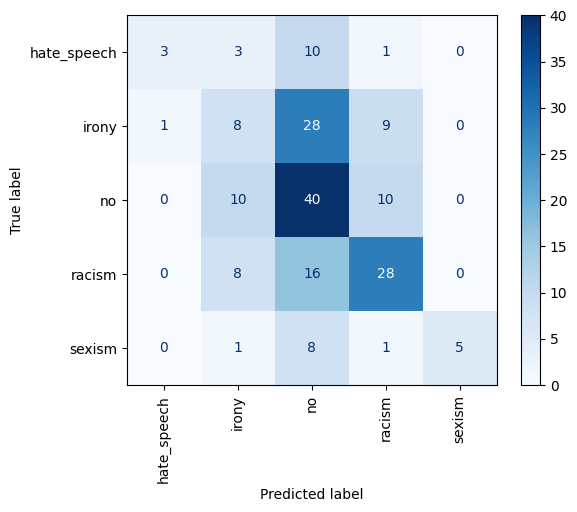

In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define SVM model with a linear kernel
model = SVC(kernel='linear', random_state=42)

# Lists to store actual and predicted values
Y_true = []
Y_pred = []

# Apply LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Pandas Series

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make a prediction
    y_pred = model.predict(X_test)

    # Store actual and predicted values
    Y_true.append(y_test.item())  # Convert to scalar
    Y_pred.append(y_pred[0])

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()


FUSION VOTING SVM & Logistic Regression

/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.00      0.00      0.00        46
       irony       0.37      0.78      0.50        60
 hate_speech       0.56      0.58      0.57        52
          no       1.00      0.27      0.42        15

    accuracy                           0.43       190
   macro avg       0.38      0.33      0.30       190
weighted avg       0.35      0.43      0.35       190

Mean Accuracy (Fusion Voting - LOO-CV): 0.4263
Confusion Matrix:
[[ 0  0 15  2  0]
 [ 0  0 35 11  0]
 [ 0  3 47 10  0]
 [ 0  1 21 30  0]
 [ 0  0 10  1  4]]


<Figure size 600x500 with 0 Axes>

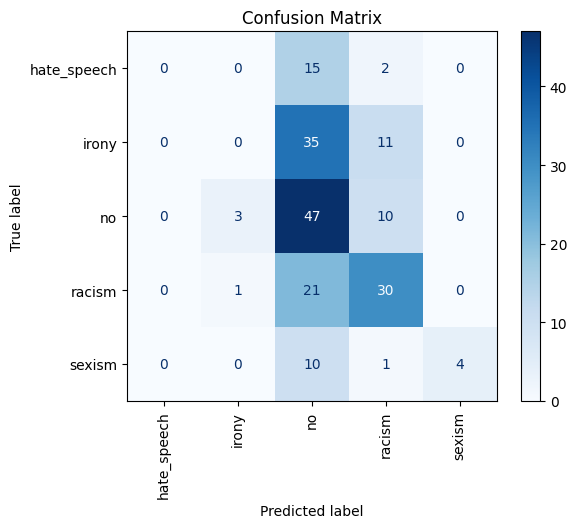

In [13]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)  # Enable probability estimates for voting

# Create a voting classifier (ensemble model)
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('svm', svm)
], voting='soft')  # Soft voting for better probability handling

# Lists to store actual and predicted labels
Y_true = []
Y_pred = []

# Apply Leave-One-Out Cross-Validation
for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the voting classifier
    voting_clf.fit(X_train, y_train)

    # Make a prediction
    y_pred = voting_clf.predict(X_test)

    # Store actual and predicted labels
    Y_true.append(y_test.values[0])   # Use .item() to get a clean value
    Y_pred.append(y_pred[0]) 

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

scores = cross_val_score(voting_clf, X, y, cv=loo, scoring='accuracy')
print(f"Mean Accuracy (Fusion Voting - LOO-CV): {np.mean(scores):.4f}")

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Display confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve Visualisation
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


FUSION VOTING CORRECTO SMOTE ONLY ON TRAINING SET

              precision    recall  f1-score   support

      racism       1.00      0.06      0.11        17
      sexism       0.28      0.17      0.21        46
       irony       0.39      0.68      0.49        60
 hate_speech       0.57      0.54      0.55        52
          no       1.00      0.33      0.50        15

    accuracy                           0.44       190
   macro avg       0.65      0.36      0.37       190
weighted avg       0.51      0.44      0.41       190

Confusion Matrix:
[[ 1  2 12  2  0]
 [ 0  8 29  9  0]
 [ 0 10 41  9  0]
 [ 0  8 16 28  0]
 [ 0  1  8  1  5]]


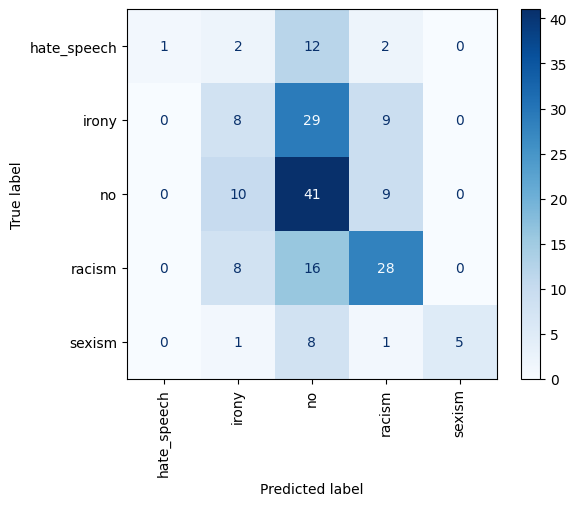

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)  # Enable probability estimates for voting

# Create a voting classifier (ensemble model)
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('svm', svm)
], voting='soft')  # Soft voting for better probability handling

# Lists to store actual and predicted labels
Y_true = []
Y_pred = []

# Apply Leave-One-Out Cross-Validation
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]  # NumPy slicing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Extract labels

    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the voting classifier
    voting_clf.fit(X_train_resampled, y_train_resampled)

    # Make a prediction
    y_pred = voting_clf.predict(X_test)

    # Store actual and predicted labels
    Y_true.append(y_test.item())  # Use .item() to get a clean value
    Y_pred.append(y_pred[0])

# Print classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()
